<a href="https://colab.research.google.com/github/Bhaktaraj-Pooja/ML-Project/blob/main/TAN_PDF_OCR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get total from Invoices of Restraurant

Step 1) Importing the libraries

In [546]:
! apt install tesseract-ocr
! apt install libtesseract-dev
!pip install pdf2image
!apt-get install poppler-utils
!pip install pytesseract
import PIL
import os
from os import listdir
from os.path import isfile, join
from pdf2image import convert_from_path
from google.colab import drive
drive.mount('/content/drive/')
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
from PIL import Image
import pytesseract
import re
from pytesseract import Output
import pandas as pd

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.62.0-2ubuntu2.12).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use

In [547]:
#Store folder path in variable
folder = "/content/drive/MyDrive/OCR_DataSet/Test/"

#Get all pdf files in the path
files = [file for file in listdir(folder) if isfile(join(folder, file)) and file.endswith('.pdf')]
print(files)

['TE_131.pdf', 'TE_158.pdf', 'TE_160.pdf', 'TE_155.pdf', 'TE_159.pdf', 'TE_161.pdf', 'TE_162.pdf', 'TE_157.pdf', 'TE_152.pdf', 'TE_154.pdf', 'TE_156.pdf', 'TE_153.pdf', 'TE_170.pdf', 'TE_166.pdf', 'TE_168.pdf', 'TE_169.pdf', 'TE_167.pdf', 'TE_174.pdf', 'TE_173.pdf', 'TE_172.pdf', 'TE_164.pdf', 'TE_165.pdf', 'TE_171.pdf', 'TE_163.pdf', 'TE_196.pdf', 'TE_189.pdf', 'TE_188.pdf', 'TE_190.pdf', 'TE_193.pdf', 'TE_194.pdf', 'TE_192.pdf', 'TE_191.pdf', 'TE_195.pdf', 'TE_187.pdf', 'TE_182.pdf', 'TE_181.pdf', 'TE_179.pdf', 'TE_180.pdf', 'TE_186.pdf', 'TE_185.pdf', 'TE_178.pdf', 'TE_177.pdf', 'TE_175.pdf', 'TE_184.pdf', 'TE_183.pdf', 'TE_176.pdf', 'TE_198.pdf', 'TE_136.pdf', 'TE_199.pdf', 'TE_133.pdf', 'TE_135.pdf', 'TE_139.pdf', 'TE_138.pdf', 'TE_134.pdf', 'TE_132.pdf', 'TE_137.pdf', 'TE_200.pdf', 'TE_197.pdf', 'TE_147.pdf', 'TE_145.pdf', 'TE_144.pdf', 'TE_146.pdf', 'TE_142.pdf', 'TE_151.pdf', 'TE_150.pdf', 'TE_143.pdf', 'TE_141.pdf', 'TE_149.pdf', 'TE_148.pdf', 'TE_140.pdf']


In [548]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [549]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [550]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [551]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [552]:
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

In [553]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [554]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

In [555]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

In [556]:
def find_amounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique

bas_filename:  TE_131.jpg
name_only:  TE_131


AttributeError: ignored

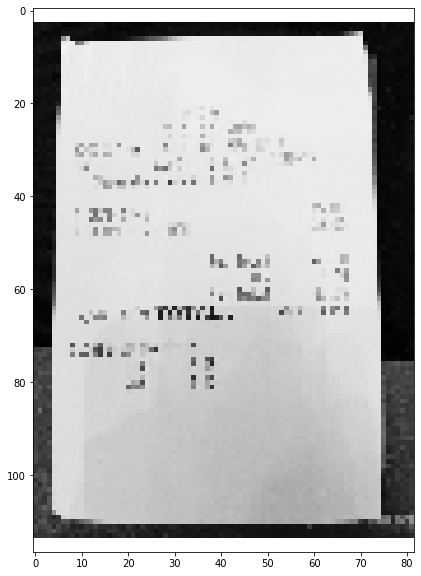

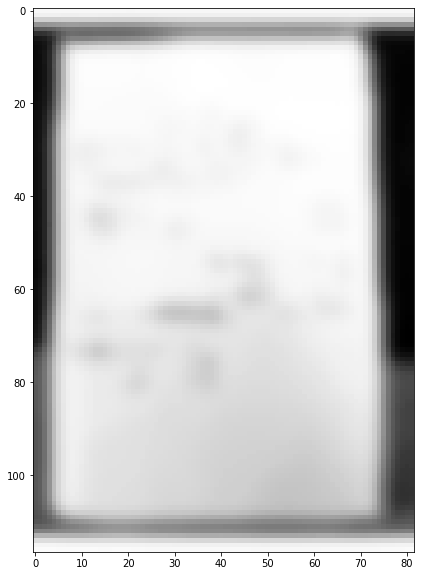

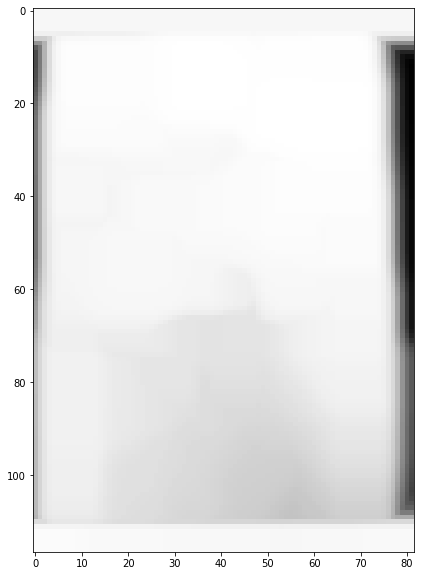

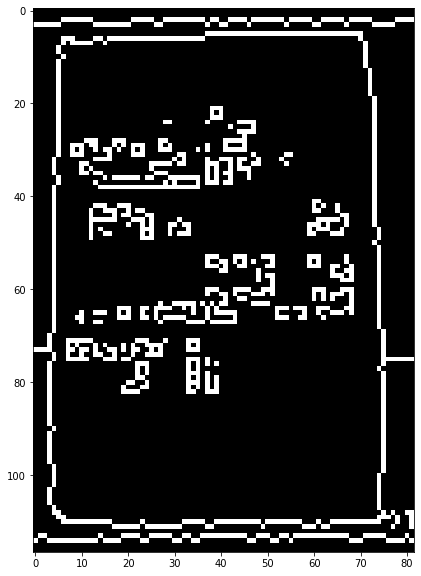

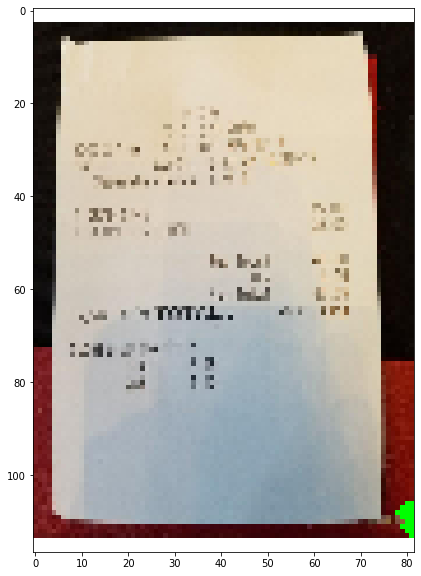

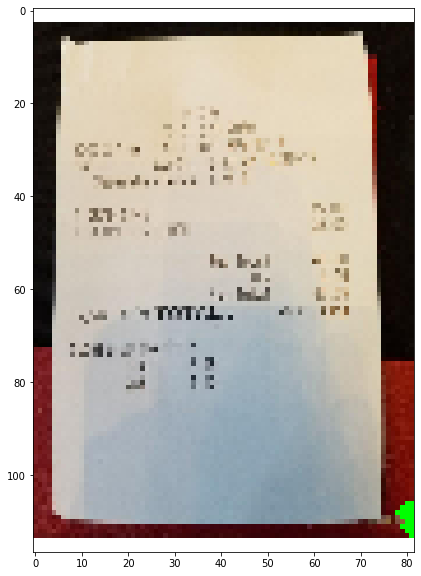

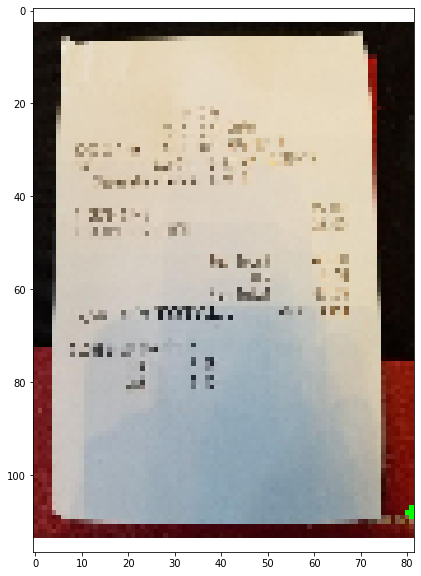

In [557]:
Submission = pd.DataFrame(columns=['FileName', 'Total Amount'])

dir_tmp = "/content/drive/MyDrive/OCR_DataSet/tmp/"
dir_image = "/content/drive/MyDrive/OCR_DataSet/image/"
i = 0

for fn in files:
    i = i +1
    images = convert_from_path(folder + fn, dpi=100, output_folder=dir_tmp, fmt='jpg', last_page=1, first_page =0)
    # image = convert_from_path(folder + fn, dpi=100, output_folder=dir_tmp, fmt='jpg', last_page=1, first_page =0, paths_only =True)
    
    # Get file name
    base_filename = os.path.splitext(os.path.basename(fn))[0] + '.jpg' 
    print("bas_filename: ", base_filename)    

    name_only = os.path.splitext(os.path.basename(fn))[0]
    print("name_only: ", name_only)

    for page in images:
            page.save(os.path.join(dir_tmp, base_filename), 'JPEG')




####### Addition of new code
    # imgfiles = [file for file in listdir(dir_tmp) if isfile(join(dir_tmp, file)) and file.endswith('.jpg')]   

    file_name = dir_tmp + base_filename
    image = cv2.imread(file_name)

    # Downscale image as finding receipt contour is more efficient on a small image
    resize_ratio = 500 / image.shape[0]
    # resize_ratio = image.shape[1]//10 / image.shape[0]//10
    original = image.copy()
    # image = opencv_resize(image, resize_ratio)
    image = cv2.resize(image, (image.shape[1]//10,image.shape[0]//10))

    # Convert to grayscale for further processing
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plot_gray(gray)

    # Get rid of noise with Gaussian Blur filter
    # blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    blurred = cv2.GaussianBlur(gray, (11, 11), 0)
    plot_gray(blurred)

    # Detect white regions
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    dilated = cv2.dilate(blurred, rectKernel)
    plot_gray(dilated)

    # edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
    edged = cv2.Canny(gray, 75, 200)
    plot_gray(edged)

    # Detect all contours in Canny-edged image
    # contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours[1], key = cv2.contourArea, reverse = True)[:5]

    image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
    plot_rgb(image_with_contours)

    # Get 10 largest contours
    largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
    image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
    plot_rgb(image_with_largest_contours)

    # get_receipt_contour(largest_contours)

    # receipt_contour = get_receipt_contour(largest_contours) 
    # image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)


    for c in contours:
        ### Approximating the contour
        #Calculates a contour perimeter or a curve length
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.01 * peri, True)
        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        screenCnt = approx
        if len(approx) == 4:
            screenCnt = approx
            break
        # show the contour (outline) 
        # print("STEP 2: Finding Boundary")
    cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
    image_with_receipt_contour = cv2.resize(image,(image.shape[1],image.shape[0]))


    plot_rgb(image_with_receipt_contour)

    if  receipt_contour.any():
        if receipt_contour.all():
            scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
            plt.figure(figsize=(16,10))
            plt.imshow(scanned)

            result = bw_scanner(scanned)
            plot_gray(result)
          
            output = Image.fromarray(result)
            output.save('result.png')

            file_name = "result.png"
            image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 
            plot_gray(image)

            d = pytesseract.image_to_data(output, output_type=Output.DICT)
            n_boxes = len(d['level'])
            boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
            for i in range(n_boxes):
                (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
                boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
                
            plot_rgb(boxes)

            extracted_text = pytesseract.image_to_string(image)
            # print(extracted_text)

            amounts = find_amounts(extracted_text)
            # amounts

            # max(amounts)

            if amounts:

                i_str = str(i)

                # Submission[i].File_name = name_only+i_str
                # Submission[i].Tot_amount = max(amounts)
                
                print(name_only, max(amounts))

                # Submission[i] = pd.DataFrame({"FileName":[name_only],
                #                      "Total Amount":[max(amounts)]})

                Submission = Submission.append({'FileName':[name_only],
                                  'Total Amount':[max(amounts)]}, ignore_index = True)

# # rename columns 
# Submission = Submission.rename(columns={output.columns[0]: 'File Name'})
# Submission = Submission.rename(columns={output.columns[1]: 'Total Amount'})

# write output file to Google drive
output_path = '/content/drive/MyDrive/PDF_OCR_FinalAssesment.csv'
Submission.to_csv(output_path, index=False)

In [ ]:
#imgfiles = [file for file in listdir(dir_tmp) if isfile(join(dir_tmp, file)) and file.endswith('.jpg')]
#print(imgfiles)

In [ ]:
# file_name = dir_tmp + "TE_160.jpg"
# image = cv2.imread(file_name)
# # Downscale image as finding receipt contour is more efficient on a small image
# resize_ratio = 500 / image.shape[0]
# original = image.copy()
# image = opencv_resize(image, resize_ratio)

In [ ]:
# # Convert to grayscale for further processing
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# plot_gray(gray)

In [ ]:
# # Get rid of noise with Gaussian Blur filter
# blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# plot_gray(blurred)

In [ ]:
# # Detect white regions
# rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
# dilated = cv2.dilate(blurred, rectKernel)
# plot_gray(dilated)

In [ ]:
# edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
# plot_gray(edged)

In [ ]:
cv2.__version__

In [ ]:
# # Detect all contours in Canny-edged image
# contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
# plot_rgb(image_with_contours)

In [ ]:
# # Get 10 largest contours
# largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
# image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
# plot_rgb(image_with_largest_contours)

In [ ]:
# get_receipt_contour(largest_contours)

In [ ]:
## receipt_contour = get_receipt_contour(largest_contours)
## image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
## plot_rgb(image_with_receipt_contour)

In [ ]:
# scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
# plt.figure(figsize=(16,10))
# plt.imshow(scanned)

In [ ]:
# result = bw_scanner(scanned)
# plot_gray(result)

In [ ]:
# output = Image.fromarray(result)
# output.save('result.png')

In [ ]:
# file_name = "result.png"
# image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 
# plot_gray(image)

In [ ]:
# d = pytesseract.image_to_data(output, output_type=Output.DICT)
# n_boxes = len(d['level'])
# boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
# for i in range(n_boxes):
#     (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
#     boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
# plot_rgb(boxes)

In [ ]:
# extracted_text = pytesseract.image_to_string(image)
# print(extracted_text)

In [ ]:
# amounts = find_amounts(extracted_text)
# amounts

In [ ]:
# max(amounts)

In [ ]:
# df = pd.DataFrame(columns=['File Name', 'Total Amount'])
# df1 = df = pd.DataFrame({"File Name":[base_filename],
#                          "Total Amount":[max(amounts)]})
# df1